In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from pv_parser import loop_table

In [2]:
fs = 200 # Hz, sampling frequency
dt = 1./fs # seconds, time between samples

data = pd.read_excel("2445_PVloop5mili.xlsx", engine='openpyxl')

In [3]:
# Break continuous data into cycles, then extract features from each cycle
df, V_cycles, P_cycles, t0 = loop_table( data, fs )

/Users/miafreiberg/miniconda3/envs/jack_dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


<Figure size 640x480 with 0 Axes>

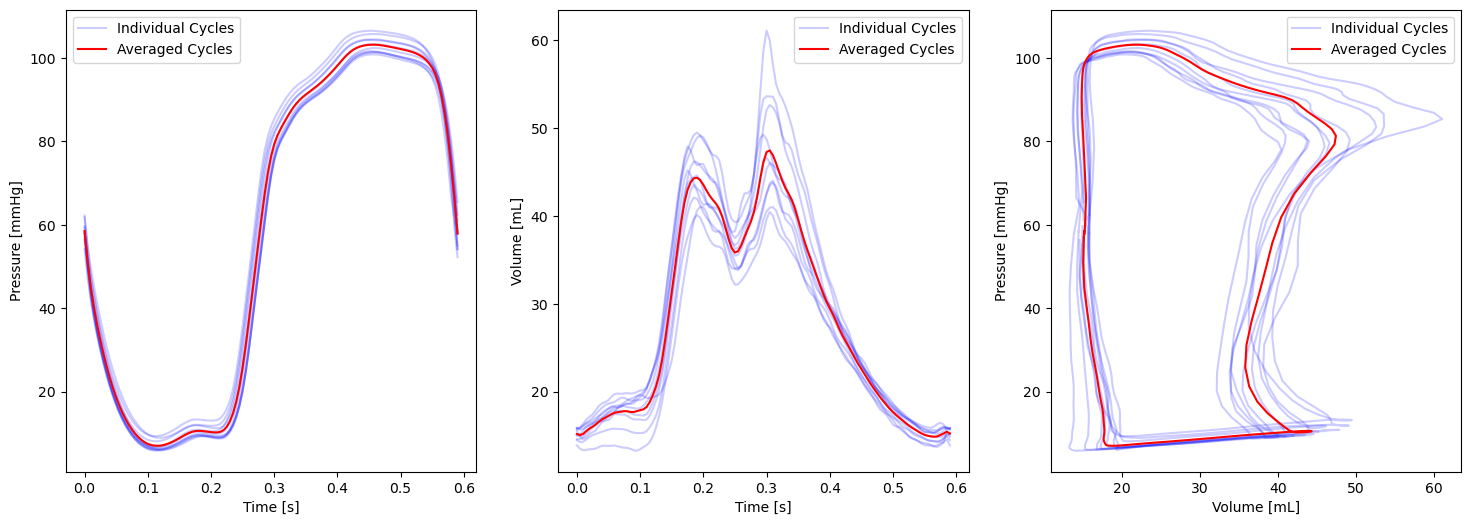

In [15]:
# Look at the short term behavior of the data
# Make a simple average of the pressure and volume traces over a few cycles
trace_range = np.arange(1, 11)

Ptrace_stack = list()
Vtrace_stack = list()
max_len = 0

# collect traces
for i in trace_range:
    P = P_cycles[i]
    V = V_cycles[i]
    
    Ptrace_stack.append(P)
    Vtrace_stack.append(V)
    
    if len(P)>max_len:
        max_len=len(P)

# Pad traces before averaging
padded_Pstack = list()
padded_Vstack = list()

for trace in Ptrace_stack:
    Npad = max_len-len(trace)
    padded_Pstack.append( np.pad(trace, (0, Npad), 'wrap'))

for trace in Vtrace_stack:
    Npad = max_len-len(trace)
    padded_Vstack.append( np.pad(trace, (0, Npad), 'wrap'))


mean_Ptrace = np.mean( np.vstack(padded_Pstack), axis=0 )
mean_Vtrace = np.mean( np.vstack(padded_Vstack), axis=0 )
tgrid = np.arange(len(mean_Ptrace))*dt

plt.clf()
fig, ax = plt.subplots(1,3,figsize=(18,6))

for i in range(len(padded_Pstack)):
    if i==0:
        ax[0].plot( tgrid, padded_Pstack[i], c='b', alpha=0.2, label='Individual Cycles' ) 
        ax[1].plot( tgrid, padded_Vstack[i], c='b', alpha=0.2, label='Individual Cycles' )
        ax[2].plot( padded_Vstack[i], padded_Pstack[i], c='b', alpha=0.2, label='Individual Cycles' )

    else:
        ax[0].plot( tgrid, padded_Pstack[i], c='b', alpha=0.2 ) 
        ax[1].plot( tgrid, padded_Vstack[i], c='b', alpha=0.2 )
        ax[2].plot( padded_Vstack[i], padded_Pstack[i], c='b', alpha=0.2 )

ax[0].plot( tgrid, mean_Ptrace, c='r', label='Averaged Cycles' )
ax[1].plot( tgrid, mean_Vtrace, c='r', label='Averaged Cycles' )
ax[2].plot( mean_Vtrace, mean_Ptrace, c='r', label='Averaged Cycles' )
ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlabel("Time [s]")
ax[1].set_xlabel("Time [s]")
ax[2].set_xlabel("Volume [mL]")
ax[0].set_ylabel("Pressure [mmHg]")
ax[1].set_ylabel("Volume [mL]")
ax[2].set_ylabel("Pressure [mmHg]")

plt.show()
#print(trace_range)

<Figure size 640x480 with 0 Axes>

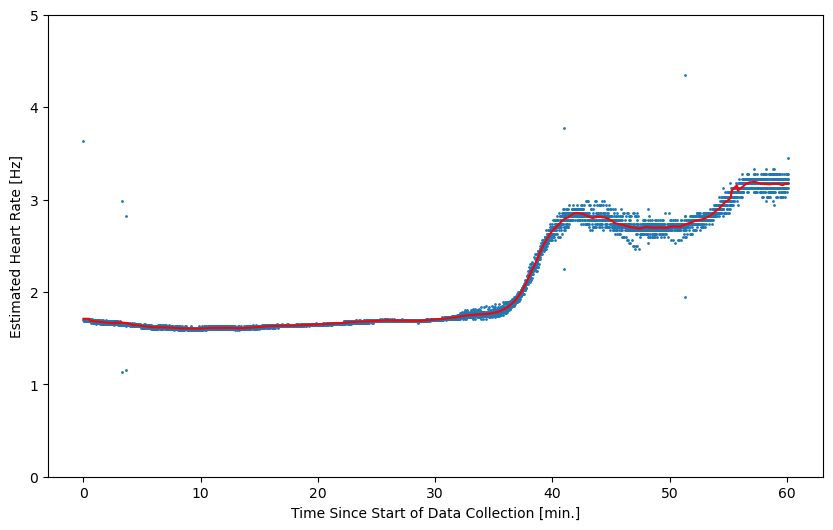

<Figure size 640x480 with 0 Axes>

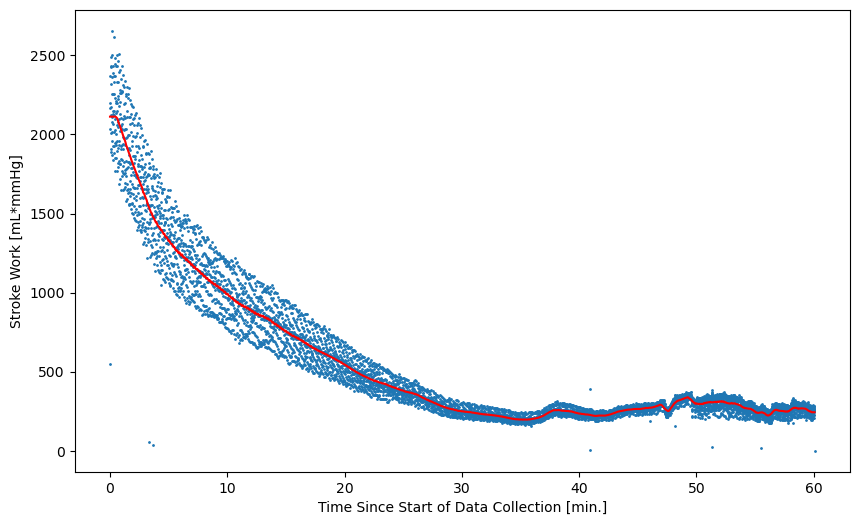

<Figure size 640x480 with 0 Axes>

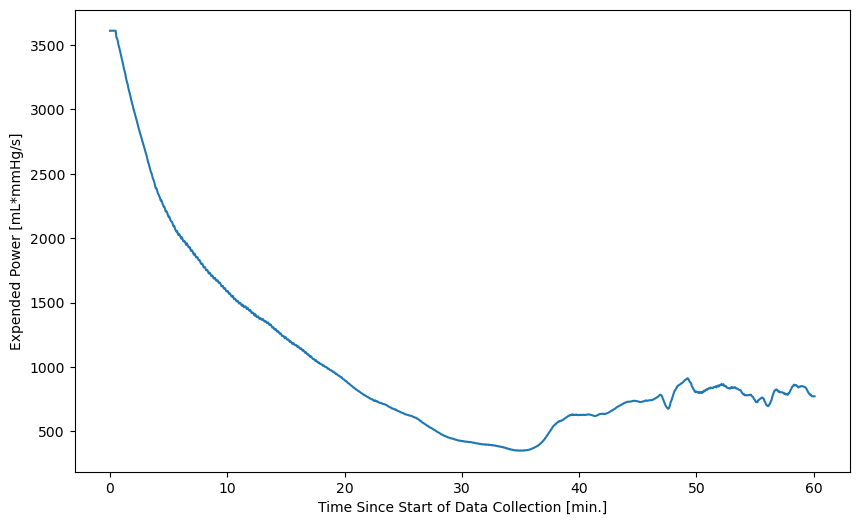

In [17]:
# Look at the long term behavior of the data
# Estimate the heart rate and associated power as a function of time over the experiment

# We will use a k-Nearest Neighbors regressor to average our the cycle-to-cycle variations
# I'm just using a reasonable guess for k for now. In the future we should split the data and cross-validate to choose k.

t_center = (0.5*(t0[:-1]+t0[1:]))[:,np.newaxis]
dt = np.diff(t0)

# Initialize kNN regessor for heart rate
neigh_HR = KNeighborsRegressor(n_neighbors=100)
# Initialize kNN regessor for heart work
neigh_HW = KNeighborsRegressor(n_neighbors=100)


# Fit kNN regessor for heart rate
neigh_HR.fit( t_center, 1./dt )
# Fit kNN regessor for heart work
neigh_HW.fit( t0[:,np.newaxis], df["Work"] )

test_grid = np.linspace( 0, np.amax(t0), 1000 )[:,np.newaxis]

# generate predictions
rate_p = neigh_HR.predict(test_grid)
work_p = neigh_HW.predict(test_grid)

plt.clf()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter( t_center/60, 1./dt, s=1 )
ax.plot( test_grid/60, rate_p, c='r' )
plt.xlabel("Time Since Start of Data Collection [min.]")
plt.ylabel("Estimated Heart Rate [Hz]")
plt.ylim(0, 5)
plt.show()

plt.clf()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter( t0/60, df["Work"], s=1 )
ax.plot( test_grid/60, work_p, c='r' )
plt.xlabel("Time Since Start of Data Collection [min.]")
plt.ylabel("Stroke Work [mL*mmHg]")
plt.show()

plt.clf()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot( test_grid/60, work_p*rate_p )
plt.xlabel("Time Since Start of Data Collection [min.]")
plt.ylabel("Expended Power [mL*mmHg/s]")
plt.show()